# MNIST with PyTorch
In this notebook, we will implement a fully connected network that classifies
handwritten digits.

This time, we will use the torchvision mnist dataset. The underlying data is
the same as in the Keras version, but torchvision is easier to interface with
from PyTorch.

In [8]:
from torchvision.datasets import MNIST
from torchvision import transforms
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

%matplotlib inline

DEVICE = torch.device("cuda") # Put your device string here.

First, let's setup our dataset, as we did in the micrograd example. In addition,
we will visualize a sample data point.

Text(0.5, 1.0, 'Ground truth=5')

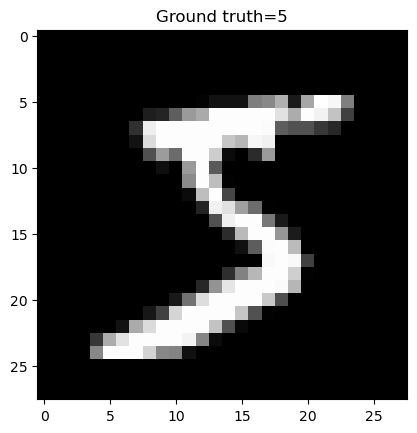

In [9]:
train_set = MNIST("data", download=True, train=True, transform=transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize((0.1307,), (0.3081,))
]), target_transform=transforms.Compose([torch.tensor, lambda y: F.one_hot(y, 10)]))
train_loader = torch.utils.data.DataLoader(train_set, batch_size=1024)
test_set = MNIST("data", download=True, train=False, transform=transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize((0.1307,), (0.3081,))
]), target_transform=transforms.Compose([torch.tensor]))
plt.imshow(train_set[0][0][0], cmap="gray")
plt.title(f"Ground truth={train_set[0][1].argmax()}")

Let's first implement our model class.

In [10]:
class MNISTNet(nn.Module):
  def __init__(self):
    super().__init__()
    # Note the use of nn.Sequential here for convenience.
    self.layers = nn.Sequential(
      nn.Flatten(),
      nn.Linear(784, 800),
      nn.ReLU(),
      nn.Linear(800, 10)
    )

  def forward(self, x):
    return self.layers(x) # Using nn.Sequential makes this easy.

Now we will instantiate our model, loss function, and optimizer:

In [19]:
model = MNISTNet()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)
model.to(DEVICE)

MNISTNet(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=800, bias=True)
    (2): ReLU()
    (3): Linear(in_features=800, out_features=10, bias=True)
  )
)

This time, now that we have a much more powerful engine, we can actually train
our model!

Specifically note that instead of performing full-batch gradient descent, like
we did in `iris.ipynb`, we are using "mini-batch" gradient descent, so that we
aren't training on the entire dataset at once.

In [20]:
for epoch in range(100):
  for i, (x, y) in enumerate(train_loader):
    x,y = x.to(DEVICE), y.to(DEVICE)
    optimizer.zero_grad()
    y_pred = model(x).softmax(dim=1)
    loss = loss_fn(y_pred, y.float())
    loss.backward()
    optimizer.step()
  print(f"Epoch {epoch} loss: {loss}")

Epoch 0 loss: 2.026780128479004
Epoch 1 loss: 1.7903779745101929
Epoch 2 loss: 1.7348846197128296
Epoch 3 loss: 1.6685311794281006
Epoch 4 loss: 1.6433109045028687
Epoch 5 loss: 1.6189539432525635
Epoch 6 loss: 1.581926703453064
Epoch 7 loss: 1.5661852359771729
Epoch 8 loss: 1.557105541229248
Epoch 9 loss: 1.5510523319244385
Epoch 10 loss: 1.5466315746307373
Epoch 11 loss: 1.543205976486206
Epoch 12 loss: 1.5404380559921265
Epoch 13 loss: 1.538130521774292
Epoch 14 loss: 1.5361509323120117
Epoch 15 loss: 1.5344170331954956
Epoch 16 loss: 1.5328688621520996
Epoch 17 loss: 1.5314689874649048
Epoch 18 loss: 1.5301897525787354
Epoch 19 loss: 1.5290038585662842
Epoch 20 loss: 1.5278979539871216
Epoch 21 loss: 1.5268598794937134
Epoch 22 loss: 1.5258777141571045
Epoch 23 loss: 1.5249364376068115
Epoch 24 loss: 1.524032473564148
Epoch 25 loss: 1.523157000541687
Epoch 26 loss: 1.522311806678772
Epoch 27 loss: 1.5214866399765015
Epoch 28 loss: 1.520682454109192
Epoch 29 loss: 1.5198901891708374

In [21]:
print("Final Accuracy:", sum(torch.argmax(model(x.to(DEVICE)), dim=1) == y.to(DEVICE) for x, y in test_set) / len(test_set))

Final Accuracy: tensor([0.9507], device='cuda:0')


Now that our model is trained, try running it on some test examples, and see how it does!

Text(0.5, 0, 'Prediction=6')

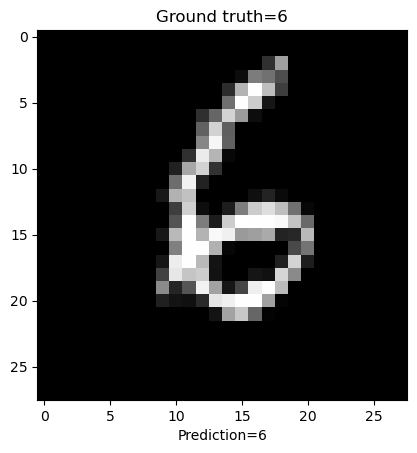

In [22]:
SAMPLE_IDX = 2000
x, y = test_set[SAMPLE_IDX]
plt.imshow(x[0], cmap="gray")
plt.title(f"Ground truth={y}")
pred = torch.argmax(model(x.to(DEVICE)))
plt.xlabel(f"Prediction={pred}")